#### Problem Statement:

In order to differentiate between original and forged signatures a Siamese network was built which gives the similarity scores between pairs of signature images which are compared with each other to ensure authenticity.

#### Import Required Libraries:

In [1]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Input,GlobalAveragePooling2D,Dense,Lambda
from tensorflow.keras import Model
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import split_folders
import cv2
from tensorflow.keras.preprocessing import image_dataset_from_directory
import math

#### Building the model using VGG16

In [2]:
# Defining a function to build the network architecture
def build_siamese_model(input_shape,embedding_dim,fine_tune=False):
    inputs=Input(input_shape)
    preprocess_func=preprocess_input
    base_model=VGG16(input_shape=input_shape,include_top=False)
    
    
    # Training only the newly added Dense layers and freezing the rest of the layers
    if fine_tune==False:
        base_model.trainable=False
        print(base_model.layers)
    else:
        base_model.trainable=True
        
        # Tune the model from this layer
        fine_tune_from=len(base_model.layers)-1
        
        # Freezing all layers befor fine_tune
        for layer in base_model.layers[:fine_tune_from]:
            layer.trainable=False
            
    # Assigning new layers to the model to be trained
    x=base_model(inputs)
    x=GlobalAveragePooling2D()(x)
    output=Dense(embedding_dim)(x)
    model=Model(inputs,output)
    
    return model

model=build_siamese_model((64,64,3),64,True)
model.summary()
        

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
Total params: 14,747,520
Trainable params: 32,832
Non-trainable params: 14,714,688
_________________________________________________________________


#### Creating Image pairs:

In [3]:
def create_pairs(images,labels):
    #Initialize 2 empty lists to hold pairs or images and lables to indiacte if the pair is positive(same) or negative (different)
    pairImages=[]
    pairLabels=[]
    
    #Total classes present in the dataset
    num_class=len(np.unique(labels))
    #Obtaining indexes of a given label
    idx=[np.where(labels==i)[0] for i in range(0,num_class)]
    
    for index in range(len(images)):
        #get image and label of the iteration
        curr_image=images[index]
        label=labels[index]
        
        #Randomly choose image belonging to same class
        index_rand=np.random.choice(idx[label])
        pos_image=images[index_rand]
        
        #Make positive pair and update the empty lists initialised
        pairImages.append([curr_image,pos_image])
        pairLabels.append([1])
        
        #Obtaining indexes of labels not equal to current label and its corresponding image
        neg_idx=np.where(labels !=label)[0]
        neg_image=images[np.random.choice(neg_idx)]
        
        #Make negative pair and update list
        pairImages.append([curr_image,neg_image])
        pairLabels.append([0])
        
    return (np.array(pairImages),np.array(pairLabels))

#### Calculating Euclidean Distance:

In [4]:
def euclidean_distance(vectors):
    # unpack the vectors into separate lists
    (featsA, featsB) = vectors
    # compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1,
                       keepdims=True)
    # return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))
    

In [5]:
from tensorflow.keras.datasets import mnist

#### Loading Data:

In [6]:
#Splitting the dataset into Train & Validation sets
split_folders.ratio("D:/MTech-DSML/Main Projects/Signature Recognition_SiameseNW/sample_Signature/sample_Signature","D:/MTech-DSML/Main Projects/Signature Recognition_SiameseNW/sample_Signature/output",
               seed=1337,
    ratio=(0.8, 0.2))

Copying files: 300 files [00:00, 799.70 files/s]


#### Image Preprocessing:

#### Train data

In [7]:
data_train=image_dataset_from_directory("D:/MTech-DSML/Main Projects/Signature Recognition_SiameseNW/sample_Signature/output/train/", image_size=(64,64), batch_size=240)

Found 240 files belonging to 2 classes.


In [8]:
for data_train, labels_train in data_train.take(1):
    print(data_train.shape)
    print(labels_train.shape)

(240, 64, 64, 3)
(240,)


In [9]:
# Scaling the train data
data_train=data_train/255.

#### Validation data

In [10]:
data_val=image_dataset_from_directory("D:/MTech-DSML/Main Projects/Signature Recognition_SiameseNW/sample_Signature/output/val/", image_size=(64,64), batch_size=240)

Found 60 files belonging to 2 classes.


In [12]:
for data_val, labels_val in data_val.take(1):
    print(data_val.shape)
    print(labels_val.shape)

(60, 64, 64, 3)
(60,)


In [13]:
# Scaling the validation data
data_val=data_val/255.

In [14]:
#Train Data
(pairTrain,labelTrain)=create_pairs(data_train,labels_train)

In [15]:
# Validation Data
(pairVal,labelVal)=create_pairs(data_val,labels_val)

#### Building a Siamese Network

In [16]:
# Two inputs will pass through the network
IMG_SHAPE=(64,64,3)
img1 = Input(shape=IMG_SHAPE)
img2 = Input( shape=IMG_SHAPE)
featureExtractor = build_siamese_model(IMG_SHAPE,64)
featsA = featureExtractor(img1)
featsB = featureExtractor(img2)

[<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001F1562039B0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F14C378FD0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F15637B208>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001F156575F98>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F15636D0F0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F156567390>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001F1563D0278>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F1563D0C18>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F1565905C0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F1565B8240>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001F1565A6CF8>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F1

In [17]:
#The differencing layer to calculate the Euclidian distance between the two sister CNN networks encoding output.
distance =Lambda(euclidean_distance)([featsA, featsB])
outputs=Dense(1,activation='sigmoid')(distance)
model = Model(inputs=[img1, img2], outputs=outputs)

In [18]:
# Compiling the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [19]:
#Model Training
history = model.fit([pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:], validation_data=([pairVal[:, 0], pairVal[:, 1]], labelVal[:]), batch_size=32, epochs=50)

Epoch 1/50
15/15 [==============================] - 24s 2s/step - loss: 1.4553 - accuracy: 0.4979 - val_loss: 1.1706 - val_accuracy: 0.4917
Epoch 2/50
15/15 [==============================] - 23s 2s/step - loss: 1.0280 - accuracy: 0.4979 - val_loss: 0.9912 - val_accuracy: 0.4917
Epoch 3/50
15/15 [==============================] - 21s 1s/step - loss: 0.8952 - accuracy: 0.4979 - val_loss: 0.9193 - val_accuracy: 0.4917
Epoch 4/50
15/15 [==============================] - 21s 1s/step - loss: 0.8287 - accuracy: 0.4979 - val_loss: 0.8757 - val_accuracy: 0.4917
Epoch 5/50
15/15 [==============================] - 21s 1s/step - loss: 0.7879 - accuracy: 0.4979 - val_loss: 0.8488 - val_accuracy: 0.4917
Epoch 6/50
15/15 [==============================] - 19s 1s/step - loss: 0.7607 - accuracy: 0.4979 - val_loss: 0.8332 - val_accuracy: 0.4917
Epoch 7/50
15/15 [==============================] - 23s 2s/step - loss: 0.7381 - accuracy: 0.4979 - val_loss: 0.8201 - val_accuracy: 0.4917
Epoch 8/50
15/15 [==

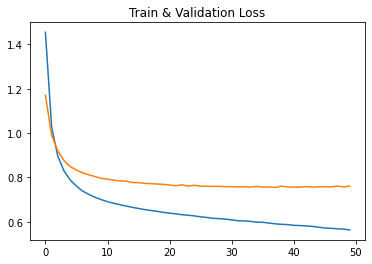

In [56]:
plt.plot(history.history['loss'],label='Train')
plt.plot(history.history['val_loss'],label='Validation')
plt.title("Train & Validation Loss")
plt.show()

#### Predict the Similarity score between 2 images:

In [52]:
preds = model.predict([pairVal[1],pairVal[2]])
preds.max()

0.7065986

#### Conclusion:

- Using binary cross entropy loss we get the similarity score between 2 images.
- The best fit model gave a loss of 0.56 on Train data and 0.76 on Test data